# Introduction 
Author: Saleban Olow<br>
Title: Apply analysis technique and machine learning models on Lending Club dataset <br>
Data From: https://www.kaggle.com/wendykan/lending-club-loan-data <br>
Last Modified: 4/29/2018


In [94]:
# libraries used on this notebook
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from wordcloud import WordCloud, STOPWORDS

from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6

# Sklearn
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics 

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA 
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
warnings.filterwarnings('ignore')

### Load data
Handy function for data loading.


In [95]:
def load_data(filename):
    """Read from local file"""
    return pd.read_csv(filename + ".csv", low_memory=False)

In [96]:
for_analysis = load_data("loan")
for_ml = for_analysis.copy()

### Making DataFrame Faster
Let's decrease our memory usage by at least 50%, <b>501.0+ MB</b> to <b>217.5 MB!</b> <br>
The data types we have in our dataset are: <b>dtypes:</b> float64(49), int64(2), object(23)

There are about 887379 entries and 74 columns in this data.<br>
Among our datatypes there are 23 objects or strings, some of those columns have unique values that are less than 100 out of <b>887379</b>. It would not be efficient to keep columns that have few rows keep repeating more than <b>800K</b>, so what we would do is convert columns that have less than 150 unique values to <b>categorical</b>. The key to converting to categorical is to ensure that there are few categories to save memory usage. If there are too many unique on each column, we should not convert.

In [98]:
def reduce_memory_usage(data):
    for x in data.columns:
        n = data[x].dtypes
        if n == "object":
            cat = data[x].nunique()
            if cat < 150:
                data[x] = data[x].astype("category")

In [99]:
reduce_memory_usage(for_analysis)

#### Slicing Long Strings.
There are many ways we can work with strings in our data. We have to keep in mind that in this data there are few rows in "loan_status" column that have long names, we want to slice that and keep everything after the 'colon'.

In [100]:
def remove_long_names(v):
    if isinstance(v, str):
        return v.replace("Does not meet the credit policy. Status:", "")
    else:
        raise TypeError("String Type is required")

#### Using Seaborn library for visualizing 'NaN' values
We'll be using a heatmap from the Seaborn library, a heatmap is a two-dimensional graphical representation of data where the individual values that are contained in a matrix are represented as colors.

Output: I would say 1/3 of our data contains null values.

In [101]:
def visualise_null(data):
    sns.set(font_scale=1.3)
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.xticks(range(len(data.columns)), data.columns, rotation=60)
    plt.show()

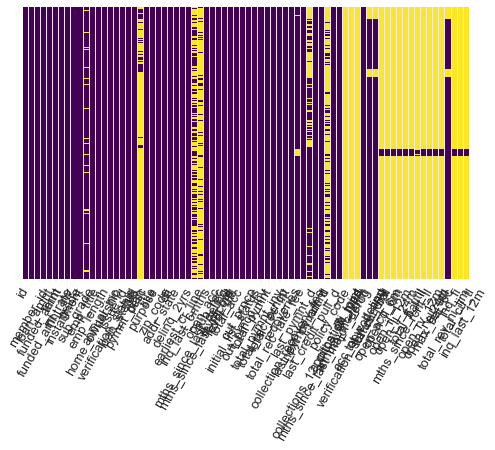

In [102]:
visualise_null(for_analysis)

#### Drop columns
We'll filter out the columns with more than 80% NULL values and then drop those columns from the DataFrame. In my opinion I don't thinking keeping a column that contains less than 20% information will provide us with a good accuracy score. Otherwise, it's your take!

In [103]:
def PercentageMissin(Dataset):
    """
        This function will return the percentage of missing values in a dataset 
        If column has over 80% missing value, del that column
    """
    if isinstance(Dataset,pd.DataFrame):
        adict={} #a dictionary conatin keys columns names and values percentage of missin value in the columns
        column = []
        for col in Dataset.columns:
            adict[col]=(np.count_nonzero(Dataset[col].isnull())*100)/len(Dataset[col])
            if adict[col] > 80:
                del adict[col]
            else:
                column.append(col)
        Dataset = Dataset.loc[:, column]
        return Dataset
    else:
        raise TypeError("can only be used with panda dataframe")

In [104]:
for_analysis['loan_status'] = for_analysis['loan_status'].apply(remove_long_names)

In [105]:
for_analysis = PercentageMissin(for_analysis) 

In [106]:
for_analysis.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


## Section 1
### Analysis

### What can we learn from this data?

A lot!, We'll do some basic and advanced analysis. We'll ask ourselves questions like, <br>
What kind of interest rate are borrowers paying?<br>
What is the Loan Status Distribution?<br>
How long are the loan terms?<br>
How much are people borrowing? For what purpose?<br>
Why do people take out loans? <br>

A bulk of this notebook will focus on machine learning aspects, we'll test different models as we explore the data further.

### Question 1: What kind of interest rate are borrowers paying?

Output: the common interest rate borrowers are paying is <b>13.24%</b><br>
To understand loan calculation >>> https://mozo.com.au/interest-rates/guides/calculate-interest-on-loan

In [107]:
for_analysis = for_analysis[for_analysis.int_rate.notnull()]
for_analysis.int_rate.describe()

count    887379.000000
mean         13.246740
std           4.381867
min           5.320000
25%           9.990000
50%          12.990000
75%          16.200000
max          28.990000
Name: int_rate, dtype: float64

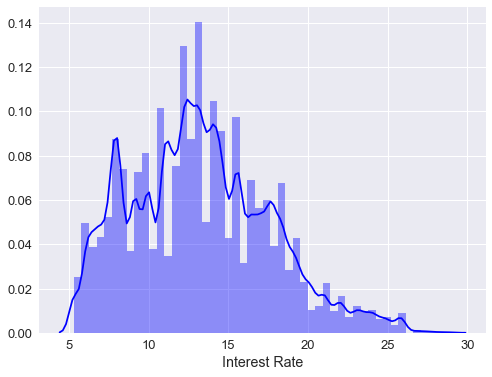

In [108]:
#Let's visualize the distribution of 'interest rate'
sns.distplot(for_analysis.int_rate, axlabel = "Interest Rate", color="blue")

### Question 2: What type of Loan Status Distribution can we identify?

It is often useful to use plot types which reduce a dataset to more descriptive statistics and provide a good summary of the data. Box and whisker plots are a classic way of summarizing univariate distributions but Seaborn provides a more sophisticated extension of the standard box plot, called a violin plot. We'll visualize the loan_status using countplot which is suitable for categorical feature variables. In order to further understand the distribution of our data we will compare that with 'loan_amnt' using a violinplot. It gives a better picture of the statistical distribution of our data and overcomes the problem of binning bias that represents the major drawback of using histograms. Violin plots show curve distributions, notably a kernel density estimate that approximates the histogram wrapped around a box plot rather than discrete points. The basic idea is that the distribution is denser where the violin plot is thicker. 

In [109]:
def plot_distribution(data):
    plt.figure(figsize=(10,8))
    
    plt.subplot(311)
    cntplt = sns.countplot(x="loan_status", data=data)
    cntplt.set_xticklabels(cntplt.get_xticklabels(), rotation = 15)
    cntplt.set_xlabel("", fontsize = 10)
    cntplt.set_ylabel("Count", fontsize = 15)
    cntplt.set_title("Loan Status Distribution", fontsize = 18)
    
    plt.subplot(312)
    vplt = sns.violinplot(x="loan_status", y="loan_amnt", data=data)
    vplt.set_xticklabels(vplt.get_xticklabels(),rotation = 15)
    vplt.set_xlabel("Duration Distribuition", fontsize=10)
    vplt.set_ylabel("Count", fontsize=15)
    vplt.set_title("Loan Amount", fontsize=18)
    
    plt.subplots_adjust(wspace = 0.2, hspace = 0.7,top = 0.9)

    plt.show()

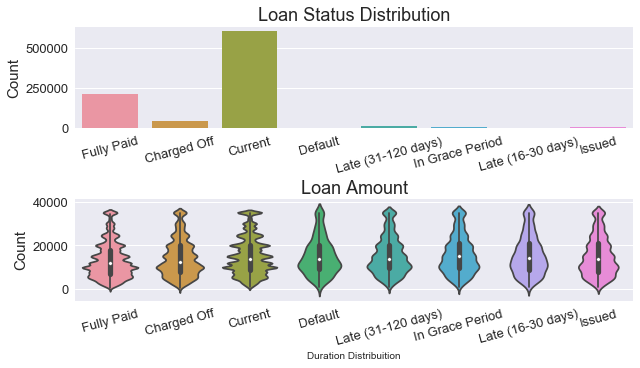

In [110]:
plot_distribution(for_analysis)

In [ ]:
# code for combination of violin plot and swarm plot

sns.violinplot(x='day', y='tip', data=tips, inner=None, color='lightgray')

sns.stripplot(x='day', y='tip', data=tips, size=4, jitter=True)

plt.ylabel('tip ($)')

plt.show()

### Question 3: How long are the loan terms?

<b>Output:</b> about 70 percent of all borrowers choose 36 months loan terms.

In [111]:
for_analysis.term.value_counts(1)

 36 months    0.699955
 60 months    0.300045
Name: term, dtype: float64

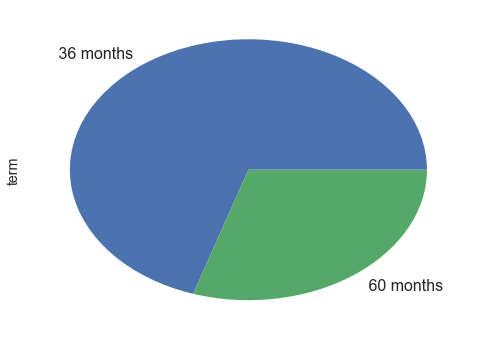

In [112]:
for_analysis.term.value_counts(1).plot(kind="pie", fontsize=16)

### Question 4(a): How much are people borrowing?

<b>Output:</b> the average amount people borrow is $14,755.

In [113]:
for_analysis.loan_amnt.describe()

count    887379.000000
mean      14755.264605
std        8435.455601
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

### Question 4(b): for what purpose?

<b>Output:</b> most people are borrowing money for 'debt', 'small business', and 'credit card'

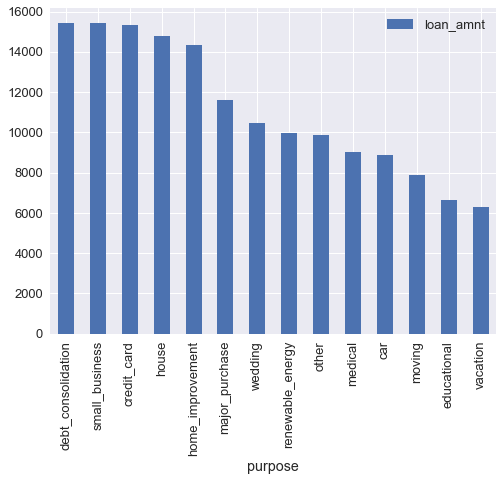

In [114]:
for_analysis.groupby('purpose').agg(
    {'loan_amnt':'mean'}).sort_values('loan_amnt', ascending=False).plot(kind='bar')

### Question 5: Why do people take out loans? 

As can be seen in the above bar chart, over 500K people take out loans because of debt repayment.

In [115]:
loan_purposes = for_analysis.purpose.value_counts()
loan_purposes

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

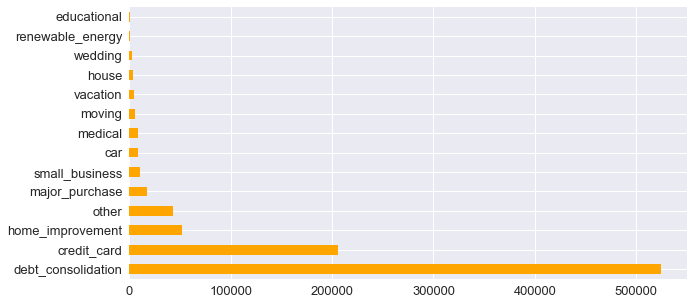

In [117]:
loan_purposes.plot.barh(figsize=(10,5), color="orange")

### WordCloud
A word-cloud is a visual representation of word frequency. The more common a term is the more it appears within the text being analysed. 

In [118]:
"""titles = for_analysis.title.str.cat(sep=',')
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_font_size=35, relative_scaling=0.2)
wordcloud.generate(titles)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()"""

'titles = for_analysis.title.str.cat(sep=\',\')\nwordcloud = WordCloud(stopwords=STOPWORDS, background_color=\'white\', max_font_size=35, relative_scaling=0.2)\nwordcloud.generate(titles)\nplt.figure(figsize=(12,6))\nplt.imshow(wordcloud)\nplt.axis("off")\nplt.show()'

#### Create a crossbat table by loan purpose and loan status

In [119]:
#Exploring the loan_status x purpose
purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(for_analysis[purp_loan[0]], for_analysis[purp_loan[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
purpose,,,,,,,,
car,461,4937,10,3249,40,81,15,70
credit_card,7895,149835,233,42521,1150,2071,381,2096
debt_consolidation,27891,356239,790,121572,3998,4796,1510,7419
educational,88,1,0,334,0,0,0,0
home_improvement,2340,34980,47,12803,367,493,137,662
house,297,1854,7,1399,37,37,15,61
major_purchase,897,10308,14,5491,125,184,51,207
medical,591,5324,15,2321,56,91,17,125
moving,440,3121,11,1634,43,52,23,90


#### Create a crossbat table by loan status and grade

In [120]:
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("orange", as_cmap=True)
pd.crosstab(for_analysis[loan_grade[0]], for_analysis[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
Charged Off,2625,9604,12790,10683,6416,3027,864
Current,103322,171735,171175,91984,47061,13589,2913
Default,47,198,360,312,201,79,22
Fully Paid,39769,66815,53159,30514,13306,4880,1268
In Grace Period,365,1240,1887,1405,908,354,94
Issued,1448,2529,2472,1185,593,194,39
Late (16-30 days),134,410,678,569,368,155,43
Late (31-120 days),492,2004,3339,2890,1852,768,246


#### Create a crosstab table by term and loan status

In [121]:
loan_grade = ['term', 'loan_status']
cm = sns.light_palette("orange", as_cmap=True)
pd.crosstab(for_analysis[loan_grade[0]], for_analysis[loan_grade[1]]).style.background_gradient(cmap = cm)

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
term,,,,,,,,
36 months,29732,402848,715,169364,3975,5982,1483,7026
60 months,16277,198931,504,40347,2278,2478,874,4565


# Section 2
## Machine Learning
In this section, we'll work on testing many ensemble models which allow us to run two or more related but different analytical models and then synthesizing the results into a single score or spread in order to improve the accuracy score. 

In our data the 'loan_status' feature tells us whether a borrower has 'Fully Paid' back a loan or 'Charged off'. So, we'll use 'loan_status' for our independent variable.

We'll start off preparing our data for machine learning, which means our data has to be all numeric. 

We'll select what features to use in our models and drop less informative features. 
We'll then encode features that have category values, for example, 'grade' column contains letter grade. 

We'll apply heatmap on features we select to see if they contain missing values, that will tell us what features to drop.

We'll apply feature scaling, using 'MinMaxScaler' from sckit-learn library. Which scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one. 

We'll split our data into train and test set using the sckit-learn library and specifically the 'train_test_split' function. This ensures that we can evaluate our model, as applying the algorithm to the data that was used for training is not indicative of how well it will generalize to new data.

We'll apply learning curve to our data, which produces a graph that compares the performance of a model on training and testing data over a varying number of training algorithms. We can learn a lot about our data from this graph. We are primarily interested in understanding how well the model will perform on unseen data. 
#### Types of learning curves:
<b>High Bias: Bad Learning Curve</b>
* When both training and testing data converge.
* No matter how much data we feed the model, its still performing poor.
* Poor generalization.

<b>High Variance: Bad Learning Curve</b>
* When there is a large gap between the errors.
* Needs more data.

<b>Ideal: Learning Curve</b>
* Model generalizes to new data.
* Training and Testing learning curves converge at similar values.
* Performance good. 


We'll apply two other functions to further understand the performance of our model. #### The Roc Curve gives us several things:
* It shows the tradeoff between sensitivity and specificity.
* The closer the curve follows the left-hand border - the more accurate the test.
* The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

#### The Confusion Matrix
A confusion matrix is a summary of prediction results on a classification problem. It gives us insight not only into the errors being made by our model but more importantly the types of errors that are being made.

We'll use 'Recursive Feature Elimination' which assigns weights to features based on feature informativeness.

We'll apply PCA to reduce the dimensionality of our data set.

Finally, we'll test few machine learning models!

In [122]:
def remove_percent_sign(v):
    if isinstance(v, float):
        return v[:-1]
    else:
        TypeError("Required float type")

In [123]:
def loan_format(data):
    if isinstance(data, pd.DataFrame):
        data = data[(data["loan_status"] == "Fully Paid") | 
                       (data["loan_status"] == "Charged Off")]
        onehotd = {"Fully Paid":0, "Charged Off":1}
        data = data.replace({"loan_status": onehotd})
        return data
    else:
        TypeError("Required dataframe type")

In [124]:
for_ml = loan_format(for_ml)
for_ml.shape

(252971, 74)

This will the features we'll be using for our machine learning models

In [125]:
features_used = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
                 'last_pymnt_amnt', 'mort_acc', 'pub_rec', 'int_rate', 'open_acc','num_actv_rev_tl',
                 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op','bc_util','bc_open_to_buy',
                 'avg_cur_bal','acc_open_past_24mths','loan_status']

for_ml = for_ml.loc[:, features_used]
for_ml = for_ml.reset_index(drop=True)
for_ml.shape

(252971, 18)

In [126]:
#for_ml.loc[:, features_used]
ready_data = for_ml.copy()

In [127]:
ready_data.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,5000.0,10+ years,24000.0,RENT,B,171.62,NaN,0.0,10.65,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2500.0,< 1 year,30000.0,RENT,C,119.66,NaN,0.0,15.27,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2400.0,10+ years,12252.0,RENT,C,649.91,NaN,0.0,15.96,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10000.0,10+ years,49200.0,RENT,C,357.48,NaN,0.0,13.49,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5000.0,3 years,36000.0,RENT,A,161.03,NaN,0.0,7.90,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [128]:
ready_data['loan_status'].value_counts()

0    207723
1     45248
Name: loan_status, dtype: int64

In [129]:
def data_encoding(data):
    if isinstance(data, pd.DataFrame):
        data['grade'] = data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
        data["home_ownership"] = data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
        data["emp_length"] = data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
        data["emp_length"] = data["emp_length"].apply(lambda x:int(x))
        data.dropna(how='any')
        return data.head()
    else:
        TypeError("Required DataFrame")

In [130]:
new_data = ready_data.copy()

In [131]:
data_encoding(new_data)

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,5000.0,10,24000.0,5,6,171.62,NaN,0.0,10.65,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2500.0,1,30000.0,5,5,119.66,NaN,0.0,15.27,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2400.0,10,12252.0,5,5,649.91,NaN,0.0,15.96,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,10000.0,10,49200.0,5,5,357.48,NaN,0.0,13.49,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5000.0,3,36000.0,5,7,161.03,NaN,0.0,7.90,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0



We'll apply heatmap on features we select to see if they contain missing values, that will tell us what features to drop.

In [132]:
def plot_missing(data):
    sns.set(font_scale = 1.25) #font size
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.xticks(range(len(data.columns)), data.columns, rotation=60)
    plt.show()

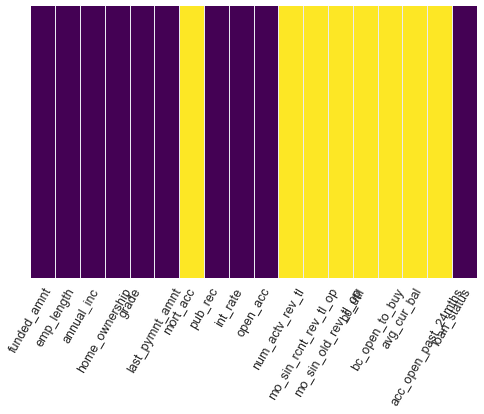

In [133]:
plot_missing(new_data)

##### We can remove these features
It is safe to say that, we can remove the following features, 'mort_acc', 'num_actv_rev_tl', 'mo_sin_rcnt_rev_fl_op', ..., 'acc_open_past_24mths'

In [134]:
def delete_cols(data):
    if isinstance(data, pd.DataFrame):
        del_col = ['num_actv_rev_tl','mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',
                   'bc_util','bc_open_to_buy','avg_cur_bal','acc_open_past_24mths', 'mort_acc']
        return data.drop(del_col, axis=1, inplace=True)
    else:
        TypeError("Required dataframe")

In [135]:
delete_cols(new_data)

In [136]:
new_data.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,5000.0,10,24000.0,5,6,171.62,0.0,10.65,3.0,0
1,2500.0,1,30000.0,5,5,119.66,0.0,15.27,3.0,1
2,2400.0,10,12252.0,5,5,649.91,0.0,15.96,2.0,0
3,10000.0,10,49200.0,5,5,357.48,0.0,13.49,10.0,0
4,5000.0,3,36000.0,5,7,161.03,0.0,7.90,9.0,0


In [137]:
new_data = new_data.fillna(new_data.mean(),inplace = True)
new_data.head() 

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,5000.0,10,24000.0,5,6,171.62,0.0,10.65,3.0,0
1,2500.0,1,30000.0,5,5,119.66,0.0,15.27,3.0,1
2,2400.0,10,12252.0,5,5,649.91,0.0,15.96,2.0,0
3,10000.0,10,49200.0,5,5,357.48,0.0,13.49,10.0,0
4,5000.0,3,36000.0,5,7,161.03,0.0,7.90,9.0,0


In [138]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = new_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(new_data[fields]), columns = fields)
data_clean['loan_status'] = new_data['loan_status']
data_clean['loan_status'].value_counts()

0    207723
1     45248
Name: loan_status, dtype: int64

In [139]:
loanstatus_0 = new_data[new_data["loan_status"]==0]
loanstatus_1 = new_data[new_data["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
new_data = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
new_data = new_data.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",new_data.shape)
new_data.head()

Current shape of dataset : (11000, 10)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,14000.0,5,55000.0,6,7,11898.00,0.0,6.03,7.0,0
1,18000.0,10,64000.0,5,7,567.30,0.0,8.39,12.0,1
2,9000.0,10,25000.0,6,5,311.95,1.0,14.99,15.0,1
3,12000.0,6,53000.0,6,5,283.22,0.0,14.64,7.0,1
4,7300.0,10,23420.0,6,5,7309.57,0.0,14.65,8.0,0


#### Before and After feature scaling
We'll apply feature scaling, using 'MinMaxScaler' from sckit-learn library. Which scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one. 

We'll plot before and after applying feature scaling.

In [140]:
up_to_date = new_data.copy()

In [147]:
def before_scale(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize= (15,7))
    ax1.set_title("Before Scaling")
    for col in data.columns:
        sns.kdeplot(data[col], ax=ax1)
        
    
    ax2.set_title("After Scaling")
    scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
    scaled_df = scaler.fit_transform(data)
    scaled_df = pd.DataFrame(scaled_df, columns=data.columns)
    for col2 in data.columns:
        sns.kdeplot(scaled_df[col2], ax = ax2)
        
    plt.show()

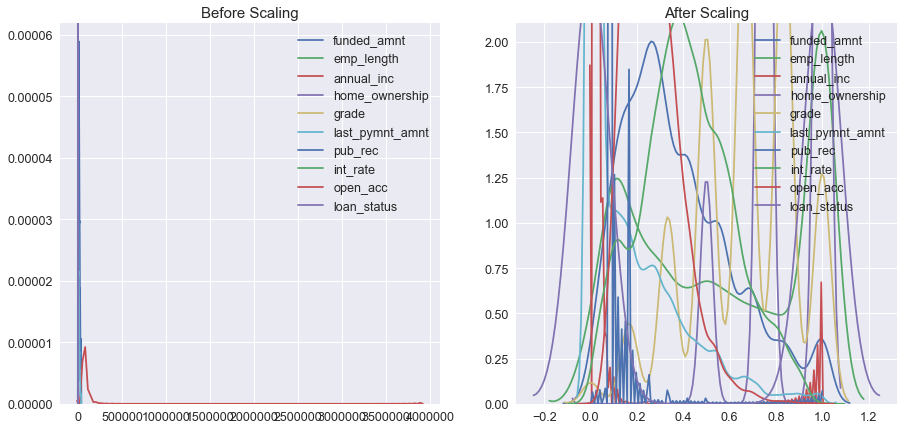

In [148]:
before_scale(up_to_date)

In [149]:
scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
scaled_df = scaler.fit_transform(new_data)
scaled_df = pd.DataFrame(scaled_df, columns=new_data.columns)

In [150]:
scaled_df.head()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
0,0.382353,0.5,0.013070,1.00,1.000000,0.333434,0.000000,0.031472,0.166667,0.0
1,0.500000,1.0,0.015380,0.75,1.000000,0.015898,0.000000,0.136082,0.285714,1.0
2,0.235294,1.0,0.005370,1.00,0.666667,0.008742,0.083333,0.428635,0.357143,1.0
3,0.323529,0.6,0.012557,1.00,0.666667,0.007937,0.000000,0.413121,0.166667,1.0
4,0.185294,1.0,0.004964,1.00,0.666667,0.204846,0.000000,0.413564,0.190476,0.0


In [151]:
scaled_df.corr()

,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,pub_rec,int_rate,open_acc,loan_status
funded_amnt,1.000000,0.153906,0.326314,0.156881,-0.242948,0.394216,-0.065934,0.242924,0.200333,0.062768
emp_length,0.153906,1.000000,0.084972,0.155378,-0.030427,0.098921,0.015011,0.038838,0.064936,-0.020095
annual_inc,0.326314,0.084972,1.000000,0.139920,0.002665,0.190627,-0.003931,-0.018504,0.117236,-0.072754
home_ownership,0.156881,0.155378,0.139920,1.000000,0.047148,0.113614,0.028995,-0.051424,0.117534,-0.062726
grade,-0.242948,-0.030427,0.002665,0.047148,1.000000,-0.000286,-0.056591,-0.951226,-0.048533,-0.268097
last_pymnt_amnt,0.394216,0.098921,0.190627,0.113614,-0.000286,1.000000,0.007407,-0.020669,0.106498,-0.574344
pub_rec,-0.065934,0.015011,-0.003931,0.028995,-0.056591,0.007407,1.000000,0.054162,-0.017690,-0.005905
int_rate,0.242924,0.038838,-0.018504,-0.051424,-0.951226,-0.020669,0.054162,1.000000,0.055616,0.292658
open_acc,0.200333,0.064936,0.117236,0.117534,-0.048533,0.106498,-0.017690,0.055616,1.000000,0.008805
loan_status,0.062768,-0.020095,-0.072754,-0.062726,-0.268097,-0.574344,-0.005905,0.292658,0.008805,1.000000


In [152]:
scaled_df.shape

(11000, 10)

#### train_test_split function

We'll split our data into train and test set using the sckit-learn library and specifically the 'train_test_split' function.

In [153]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:, :-1], scaled_df.iloc[:, -1], 
                                                    test_size = .3, random_state = 42)
print(">>>> X_train size: {}".format(X_train.shape))
print(">>>> X_test size: {}".format(X_test.shape))
print()
print(">>>> y_train size: {}".format(y_train.shape))
print(">>>> st size: {}".format(y_test.shape))

>>>> X_train size: (7700, 9)
>>>> X_test size: (3300, 9)

>>>> y_train size: (7700,)
>>>> st size: (3300,)


#### Plot Learning Curve
We'll apply learning curve to our data, which produces a graph that compares the performance of a model on training and testing data over a varying number of training samples. We can learn a lot about our data from this graph.
##### Types of learning curves:
<b>High Bias: Bad Learning Curve</b>
* When both training and testing data converge.
* No matter how much data we feed the model, its still performing poorly.
* Characterised by poor generalization.

<b>High Variance: Bad Learning Curve</b>
* When there is a large gap between the errors.
* Needs more data.

<b>Ideal: Learning Curve</b>
* Model generalizes to new data.
* Training and Testing learning curves converge at similar values.
* Performance good.

In [154]:
def plot_lcurve(estimator, title, x, y, ylim=None, cv=None, n_jobs=-1, train_size = np.linspace(.1, 1.0, 4)):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Data")
    plt.ylabel("Score")
    train_size, train_scores, test_scores = learning_curve(estimator, x, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_size, train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha = 0.1, color = 'red')
    plt.fill_between(train_size, test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha = 0.1, color = 'green')
    plt.plot(train_size, train_scores_mean, 'o-', color = 'red', label = 'Training Score')
    plt.plot(train_size, test_scores_mean, 'o-', color = 'green', label = 'Cross-validations score')
    
    plt.legend(loc='best')
    return plt

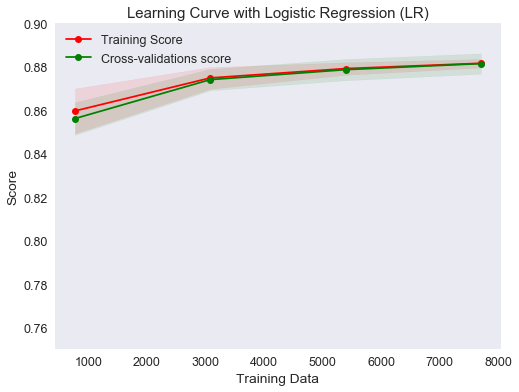

In [155]:
X, y = scaled_df.iloc[:, :-1].values, scaled_df.iloc[:, -1].values
title = "Learning Curve with Logistic Regression (LR)"
cv = ShuffleSplit(n_splits = 100, test_size = 0.3, random_state = 42)
estimator = linear_model.LogisticRegression()
plot_lcurve(estimator, title, X, y, ylim = (0.75, 0.90), cv = cv, n_jobs = -1)
plt.show()

### Let's define our other functions for plotting
ROC Curve and Confusion Matrix. 

### ROC Curve Function
We'll apply two other functions to further understand the performance of our model. #### The Roc Curve gives us several things:
* It shows the tradeoff between sensitivity and specificity.
* The closer the curve follows the left-hand border - the more accurate the test.
* The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [156]:
def plot_roc(truth, pred, title):
    fpr, tpr, _ = metrics.roc_curve(truth, pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color = c, lw = lw, label = title + " (AUC = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'slateblue', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')

### Confusion Matrix Function
#### The Confusion Matrix
A confusion matrix is a summary of prediction results on a classification problem. It gives us insight not only into the errors being made by our model but more importantly the types of errors that are being made.

In [157]:
def plot_c_matrix(model, normalize=False):
    c_matrix = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.cool
    title = "Confusion Matrix"
    if normalize:
        c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
        c_matrix = np.around(c_matrix, decimals=3)
        
    plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = c_matrix.max() / 2.0
    
    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
        plt.text(j, i, c_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if c_matrix[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Recursive Feature Elimination for feature selection
We'll use 'Recursive Feature Elimination' which assigns weights to features based on feature informativeness.

In [158]:
classifier = linear_model.LogisticRegression(C=1e30)
classifier.fit(X_train, y_train)
Re_fe = RFE(classifier, 9)
Re_fe = Re_fe.fit(scaled_df.iloc[:, :-1].values, scaled_df.iloc[:, -1].values)

### PCA
We'll apply PCA to reduce the dimensionality of our data set.

In [159]:
pca = PCA(n_components = 9, whiten = True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance is: " + str(explained_variance))

Explained Variance is: [  3.89222094e-01   2.66506937e-01   1.65306537e-01   6.83763859e-02
   6.50351571e-02   3.55714198e-02   6.06189564e-03   3.62644076e-03
   2.93132852e-04]


### Model 1 - Random Forest
We'll use the random forest algorithm to fit a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [160]:
rand_forest = RandomForestClassifier(criterion = 'gini', random_state = 42)
maxFeatures  = range(1, scaled_df.shape[1]-1)
param_dt = dict(max_features = maxFeatures )
rand = RandomizedSearchCV(rand_forest, param_dt, cv = 10, scoring = 'accuracy', n_iter = len(maxFeatures), random_state = 42)

X = scaled_df.iloc[:, :-1].values
y = scaled_df.iloc[:, -1].values
rand.fit(X, y)
mean_score = [x.mean_validation_score for x in rand.grid_scores_]
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


Our first model gives us accuracy score of 88%

In [161]:
rf = RandomForestClassifier(bootstrap = True, criterion = 'gini', max_features = rand.best_estimator_.max_features, 
                            random_state = 42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
pred_prob = rf.predict_proba(X_test)[:, 1]
acc_score = accuracy_score(y_test, pred)
roc_score = metrics.roc_auc_score(y_test, pred)
print(acc_score)

0.886363636364


### Feature Importance 
We'll explore random forest to evaluate the importance of features to see if can get a higher accuracy score.

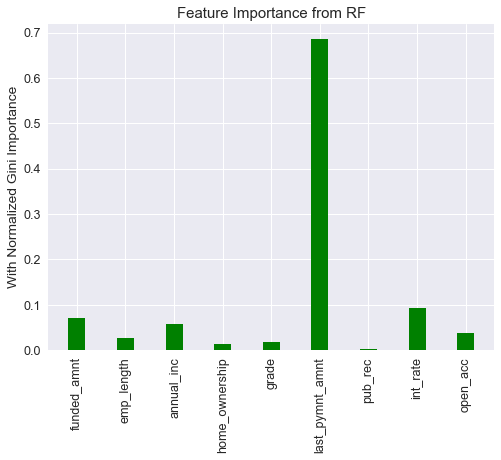

In [162]:
fig, ax = plt.subplots()
width = 0.35
ax.bar(np.arange(len(scaled_df.columns)-1), rf.feature_importances_, width, color = 'g')
ax.set_xticks(np.arange(len(rf.feature_importances_)))
ax.set_xticklabels(X_train.columns.values, rotation = 90)
plt.title("Feature Importance from RF")
ax.set_ylabel("With Normalized Gini Importance")

##### Let's plot ROC Curve and Confusion Matrix

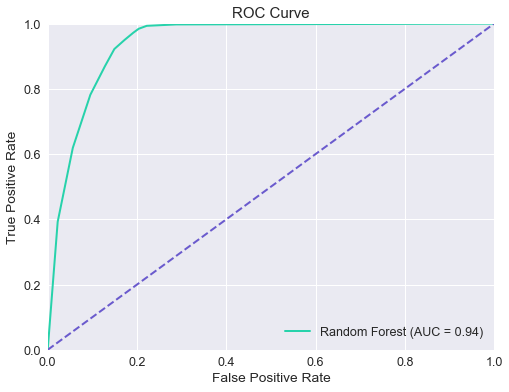

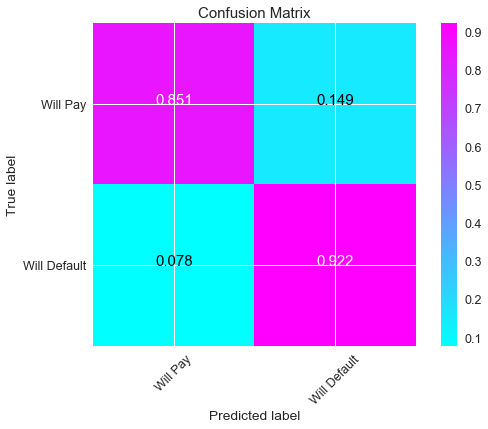

In [164]:
plot_roc(y_test, pred_prob, 'Random Forest')
plt.show()
plt.figure(figsize=(8,6))
plot_c_matrix(pred, normalize = True)
plt.show()

### Model 2 - Support Vector Machine with Grid Search
We'll work on <b>Support Vector Machines (SVMs)</b> which is a particularly powerful and flexible class of supervised learning algorithms for both classification and regression. We will develop the intuition behind SVM and their use in our data. We will combine SVM with <b>Grid-Search</b> which exhaustively searches over specified parameter values for an estimator. We will later switch to <b>'RandomizedSearchCV'</b> for robust hyper parameter tuning.

In [165]:
model_svm = svm.SVC()
cs = [10**i for i in range(0,2)]
param_gd = dict(C=cs)
grid = GridSearchCV(model_svm, param_gd, cv = 10, scoring = 'accuracy', n_jobs = -1)
grid.fit(scaled_df.iloc[:, :-1].values, scaled_df.iloc[:, -1].values)
gd_mean = [x.mean_validation_score for x in grid.grid_scores_]
print("Best params:", grid.best_params_)
print('=================================')
print(grid.best_estimator_)

Best params: {'C': 10}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVM Accuracy score:  0.877272727273


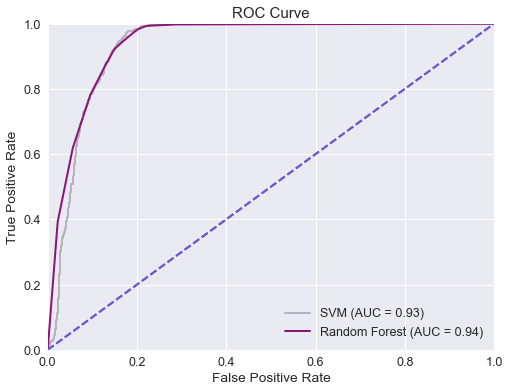

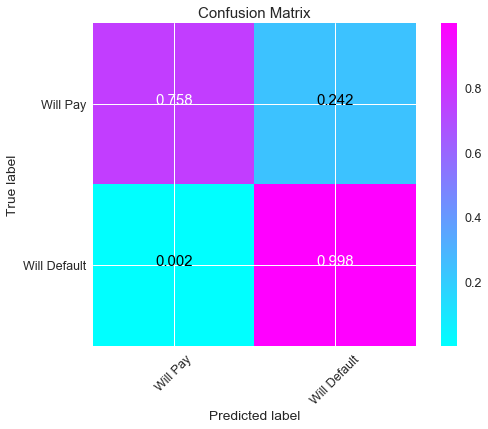

In [167]:
model_svm2 = svm.SVC(kernel = 'rbf', C = grid.best_estimator_.C)
model_svm2.fit(X_train.iloc[:, :], y_train)
pred_svm= model_svm2.predict(X_test.iloc[:, :])
pred_svm_prob = model_svm2.decision_function(X_test.iloc[:, :])
acc_svm = accuracy_score(y_test, pred_svm)
print("SVM Accuracy score: ", acc_svm)
plot_roc(y_test, pred_svm_prob, 'SVM')
plot_roc(y_test, pred_prob, 'Random Forest')
plt.show()
plt.figure(figsize = (8,6))
plot_c_matrix(pred_svm, normalize = True)
plt.show()

### K-Nearest Neighbors KNN with Grid Search
We'll work on K-Nearest-Neighbors (KNN), a powerful classification algorithm. We will go over the intuition and apply it to a our dataset to see exactly how it works.

The KNN algorithm is a robust classifier that is often used as a benchmark for more complex classifiers like SVM. KNN outperforms more powerful classifiers.

Applying grid search to our data before we fit to KNN can give us good accuracy score.

In [169]:
model_knn = KNeighborsClassifier()
krange = list(range(25, 40))
param_knn = dict(n_neighbors = krange)
grid = GridSearchCV(model_knn, param_knn, cv = 10, scoring = 'accuracy')
grid.fit(scaled_df.iloc[:, :-1].values, scaled_df.iloc[:, -1].values)
grid_mean_score = [x.mean_validation_score for x in grid.grid_scores_]
print("Best params: ", grid.best_params_)
print("======================================")
print(grid.best_estimator_)

Best params:  {'n_neighbors': 26}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='uniform')


KNN Accuracy is:  0.829696969697


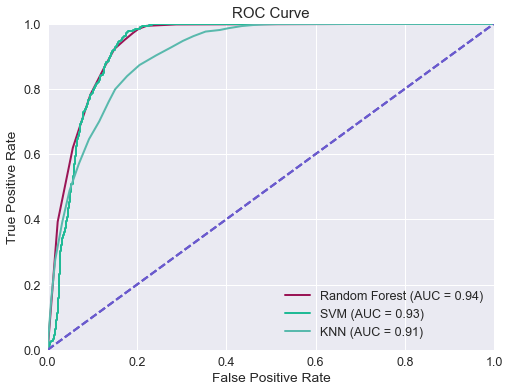

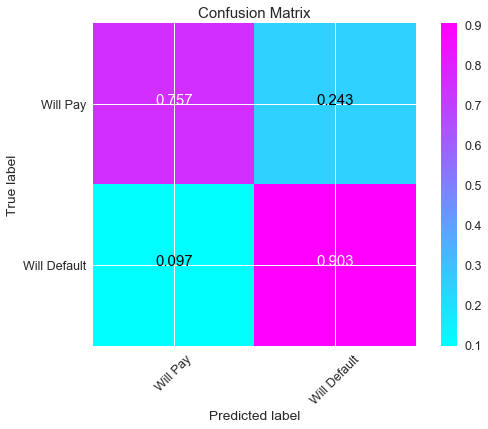

In [170]:
knn_final = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
knn_final.fit(X_train, y_train)
knn_pred = knn_final.predict(X_test)
knn_proba = knn_final.predict_proba(X_test)[:,1]
knn_acc = accuracy_score(y_test, knn_pred)

print("KNN Accuracy is: ", knn_acc)
plot_roc(y_test, pred_prob, 'Random Forest')
plot_roc(y_test, pred_svm_prob, 'SVM')
plot_roc(y_test, knn_proba, 'KNN')
plt.show()
plt.figure(figsize = (8,6))

plot_c_matrix(knn_pred, normalize = True)
plt.show()

### Bagging Classification
We'll apply the bagging classifier, which is an ensemble meta-estimator that fits base classifiers on each random subset of the original dataset and then aggregates their individual predictions (either by voting or by averaging) to form a final prediction.

In [171]:
kfold = model_selection.KFold(n_splits = 10, random_state = 42)
model_bc = BaggingClassifier(base_estimator = rf, n_estimators = 100, random_state = 42)
combo = model_selection.cross_val_score(model_bc, scaled_df.iloc[:, :-1].values, scaled_df.iloc[:, -1].values, cv = kfold)
print("Bagging Score: ", combo.mean())

Bagging Score:  0.9


### Ada Boost Classifier
We'll apply ada boost classifier, similar to bagging classifer instead of aggregating the correct individual scores, we will weight the incorrectly classified instances and adjust them such that subsequent classifiers focus more on difficult cases.

In [172]:
model_ada = AdaBoostClassifier(n_estimators = 45)
score_ada = model_selection.cross_val_score(model_ada, scaled_df.iloc[:, :-1].values, scaled_df.iloc[:, -1].values)
print("Ada Boost Score: ", score_ada.mean())

Ada Boost Score:  0.890634571607


### Multi-Layer PC - Perceptron Classifier
We'll apply multi-layer perceptron (MLP) algorithm that trains using backpropagation. This model optimizes the log-loss function using 'lbfgs':

<b> solver : {‘lbfgs’, ‘sgd’, ‘adam’}, default ‘adam’</b><br>
<b>The solver for weight optimization.</b><br>
* ‘lbfgs’ is an optimizer in the family of quasi-Newton methods.<br>
* ‘sgd’ refers to stochastic gradient descent.<br>
* ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

Multi-Layer Perceptron Classifier Score:  0.893333333333


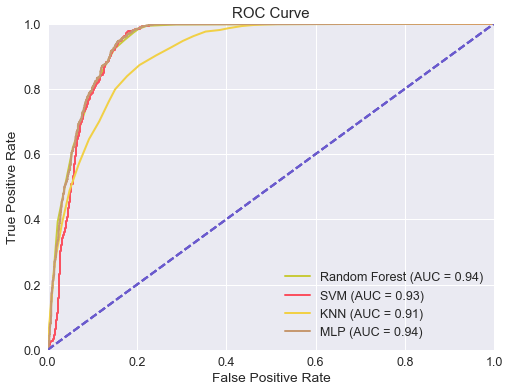

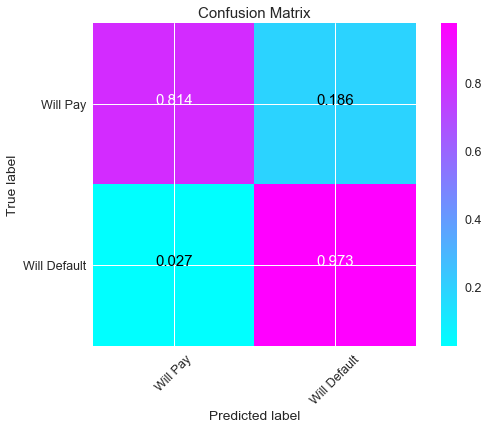

In [173]:
model_ml = MLPClassifier(solver = 'lbfgs', alpha = 1e-5, hidden_layer_sizes = (5,3), random_state = 42)
model_ml.fit(X_train, y_train)
pred_ml = model_ml.predict(X_test)
pred_ml_proba = model_ml.predict_proba(X_test)[:,1]
acc_ml = accuracy_score(y_test, pred_ml)
print("Multi-Layer Perceptron Classifier Score: ", acc_ml)
plot_roc(y_test, pred_prob, 'Random Forest')
plot_roc(y_test, pred_svm_prob, 'SVM')
plot_roc(y_test, knn_proba, 'KNN')
plot_roc(y_test, pred_ml_proba, 'MLP')
plt.show()

plt.figure(figsize = (8,6))
plot_c_matrix(pred_ml, normalize = True)
plt.show()